# Handwritten Digit Recognition with Neural Network<br><br>

<img src='drawings/title.jpg'></img>

####  Objective:
The goal of this project is to implement dense neural network and train it on the MNIST database to recognize Handwritten digits. Network will be able to have any number of layers and any number of neurons in each layer. Implementation will be done from scratch, without deep learning frameworks.

#### Content:

* [1](#1) Dataset<br>
    * [1.1](#1) Description of data<br>
    * [1.2](#1.2) Data preprocessing<br>
    * [1.3](#1.3) Final data summary<br>
* [2](#2) Utilities functions<br>
    * [2.1](#2) Spliting data into mini batches<br>
    * [2.2](#2.2) Create one hot vector<br>
    * [2.3](#2.3) Initialize parameters<br>
    * [2.4](#2.4) Network prediction<br>
    * [2.5](#2.5) Measure accurancy<br>
    * [2.6](#2.6) Activation functions<br>
        * [2.6.1](#2.6) Hidden layers activation - ReLU<br>
        * [2.6.2](#2.6.2) Output layer activation - Softmax<br>
        * [2.6.3](#2.6.3) ReLU for backward propagation<br>
* [3](#3) Model<br>
    * [3.1](#3.1) Choosing neural network architecture<br>
    * [3.2](#3.2) Parameters initialization<br>
    * [3.3](#3.3) Forward propagation<br>
    * [3.4](#3.4) Compute cost<br>
    * [3.5](#3.5) Backward propagation<br>
    * [3.6](#3.6) Update parameters (Adam optimizer)<br>
        * [3.6.1](#3.6.1) Parameters initialization for Adam optimizer<br>
    * [3.7](#3.7) Final model function<br>
* [4](#4) Training<br>
    * [4.1](#4) Hyperparameters<br>
    * [4.2](#4.2) Model performace<br>
* [5](#5) Image prediction<br>
    * [5.1](#5.1) Example<br>
* [6](#6) Conclusion<br><br>

#### Importing necessary packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.transform import resize
import imageio
import time
import pickle

<a id='1'></a>
## 1. Dataset
### 1.1 Description of data

The data for this project is wildly avalible MNIST handwritten digit database. It has a training set of 60,000 examples,
and a test set of 10,000 examples. Train set will be used to fit model, and test set will be used for model evalutation to find out for example if it is overfitting. Data is saved in CSV format and have six files:

```
 - mnist_train_part_1.csv
 - mnist_train_part_2.csv
 - mnist_train_part_3.csv
 - mnist_train_part_4.csv
 - mnist_train_part_5.csv
 - mnist_test.csv
```
Format of data in each file is the same and it is shown in table bellow:

| label |pix-1x1|pix-1x2|pix-1x3| ... |pix-28x26|pix-28x27|pix-28x28|
|-------|-------|-------|-------|-----|---------|---------|---------|
|  0-9  | 0-255 | 0-255 | 0-255 |   ..| 0-255   |   0-255 | 0-255   |
|  0-9  | 0-255 | 0-255 | 0-255 |   ..| 0-255   |   0-255 | 0-255   |
|  0-9  | 0-255 | 0-255 | 0-255 |   ..| 0-255   |   0-255 | 0-255   |
|  ...  | ...   |   ... |  ...  |   ..| ...     |   ...   | ...     |

* Each row is a new training example.
* First column is a true label for example.
* Each example is a $28x28$ image of handwritten digit in grayscale.
* Pixels of each inmage are unrolled into vector of shape $785x1$.
* $pix\!-\!ixj$ is the pixel value in $ith$ row and $jth$ column.
* Values of pixels are between $0$ and $255$.

In [2]:
# loading dataset from csv format to numpy.ndarray
train_data_part_1 = pd.read_csv('datasets/mnist_train_part_1.csv').values
train_data_part_2 = pd.read_csv('datasets/mnist_train_part_2.csv').values
train_data_part_3 = pd.read_csv('datasets/mnist_train_part_3.csv').values
train_data_part_4 = pd.read_csv('datasets/mnist_train_part_4.csv').values
train_data_part_5 = pd.read_csv('datasets/mnist_train_part_5.csv').values
train_data = np.concatenate((train_data_part_1, train_data_part_2, train_data_part_3, train_data_part_4, train_data_part_5))
test_data = pd.read_csv('datasets/mnist_test.csv').values

<a id='1.2'></a>
### 1.2 Data preprocessing
__Following steps was carried out in order to make data easier to use:__
1. The order of the examples was randomly shuffled:
```python
X_train = train_data[:, 1:]
```
2. The data sets has been divided into seperate arrays where $X$ is array of examples and $Y$ is labels for examples:
```python
X_train = train_data[:, 1:]
Y_train = train_data[:, 0]
```
3. Examples have been normalized by dividing each pixel value by 255, so all values are in the range of $0$ to $1$:
```python
X_train = X_train / 255
```

4. Shape of arrays was changed so examples are in columns and pixel values are in rows:
```python
X_train = np.transpose(X_train)
Y_train = np.reshape(Y_train, (1, Y_train.shape[0]))
```
5. Data type of $Y$ labels was changed to ```int```:
```python
Y_train = Y_train.astype(np.int8)
```


In [3]:
np.random.shuffle(train_data)
np.random.shuffle(test_data)

X_train = train_data[:, 1:]
X_train = np.transpose(X_train)
X_train = X_train / 255

Y_train = train_data[:, 0]
Y_train = np.reshape(Y_train, (1, Y_train.shape[0]))
Y_train = Y_train.astype(np.int8)

X_test = test_data[:, 1:]
X_test = np.transpose(X_test)
X_test = X_test / 255

Y_test = test_data[:, 0]
Y_test = np.reshape(Y_test, (1, Y_test.shape[0]))
Y_test = Y_test.astype(np.int8)

<a id='1.3'></a>
### 1.3 Final data summary
Legend:

* $x_{i}^{(j)}$ - value of pixel $jth$ in $ith$ training example
* $y^{(i)}$ - label for $ith$ example


<center>
$X_{train}=\begin
{bmatrix}
x_{1}^{(1)} & x_{1}^{(2)} & \dots & x_{1}^{(60000)}\\
x_{2}^{(1)} & x_{2}^{(2)} & \dots & x_{2}^{(60000)}\\
\vdots & \vdots & \ddots & \vdots\\
x_{784}^{(1)} & x_{784}^{(2)} & \dots & x_{784}^{(60000)}
\end{bmatrix}$
$,\quad$
$Y_{train}=\begin
{bmatrix}
y^{(1)} & y^{(2)} & \dots y^{(60000)}\\
\end{bmatrix}$
</center>
<br><br>
<center>
$X_{test}=\begin
{bmatrix}
x_{1}^{(1)} & x_{1}^{(2)} & \dots & x_{1}^{(10000)}\\
x_{2}^{(1)} & x_{2}^{(2)} & \dots & x_{2}^{(10000)}\\
\vdots & \vdots & \ddots & \vdots\\
x_{784}^{(1)} & x_{784}^{(2)} & \dots & x_{784}^{(10000)}
\end{bmatrix}$
$,\quad$
$Y_{test}=\begin
{bmatrix}
y^{(1)} & y^{(2)} & \dots y^{(10000)}\\
\end{bmatrix}$
</center>

In [4]:
m_train = X_train.shape[1]        # number of training examples
m_test = X_test.shape[1]          # number of testing examples
x_n = X_train.shape[0]            # number of features of each example
classes = np.unique(Y_train).size # number of diffrent classes

print(f'There are {m_train} examples in train set.')
print(f'There are {m_test} examples in test set.')
print(f'Each example have {x_n} features.')
print(f'There are {classes} diffrent classes.')

There are 60000 examples in train set.
There are 10000 examples in test set.
Each example have 784 features.
There are 10 diffrent classes.


#### Show example from train set

This is:  6


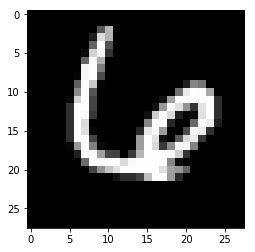

In [5]:
image = 53456
plt.imshow(X_train[:, image].reshape(28, 28), cmap='gray')
print('This is: ', Y_train[0, image])

<a id='2'></a>
## 2. Utilities functions
### 2.1 Spliting data into mini batches
* In order to train model faster examples are splited into mini batches.<br>
* Function ```mini_batches``` takes matrix with examples ```X```, labels ```Y``` for them, and desirable ```batch_size``` as an arguments.<br>
* It returns list of mini batches.
* Eachs mini batch is a tuple of two elements (examples and labels for them).

In [6]:
def mini_batches(X, Y, batch_size=64):
    m = X.shape[1] # number of training examples
    mini_batches = []
    
    # shuffle X and Y synchronously
    random_order = np.random.permutation(m)
    X_shuffled = X[:, random_order]
    Y_shuffled = Y[:, random_order]
    
    full_batches = m // batch_size # number of full batches
    last_batch_size = m % batch_size # number of examples in last batch
    
    start = 0
    for i in range(full_batches):
        end = start + batch_size
        cut_x = X_shuffled[:, start:end]
        cut_y = Y_shuffled[:, start:end]
        batch = (cut_x, cut_y)
        mini_batches.append(batch)
        start = end

    if last_batch_size != 0:
        end = start + last_batch_size
        cut_x = X_shuffled[:, start:end]
        cut_y = Y_shuffled[:, start:end]
        batch = (cut_x, cut_y)
        mini_batches.append(batch)
    
    return mini_batches

<a id='2.2'></a>
### 2.2 Create one hot vector
* One hot vector is an diffrent representation of labels which makes implementation easier:<br><br>
<center>
$Y=[2,\ 3,\ 8,\ 9,\ 0,\ 5]\quad$ $\Longrightarrow\quad one\_hot\quad \Longrightarrow\quad$
$Y_{one\_hot}=
\begin
{bmatrix}
0&0&0&0&1&0\\
0&0&0&0&0&0\\
1&0&0&0&0&0\\
0&1&0&0&0&0\\
0&0&0&0&0&0\\
0&0&0&0&0&1\\
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&1&0&0&0\\
0&0&0&1&0&0\\
\end{bmatrix}$
</center>

In [7]:
def one_hot(Y, classes):
    Y_one_hot = np.zeros([classes, Y.shape[1]])
    
    for i in range(Y.shape[1]):
        Y_one_hot[Y[0, i], i] = 1
    
    return Y_one_hot

<a id='2.3'></a>
### 2.3 Initialize parameters
* Initialize parameters according to neural network architecture.
* Normal neurons are initialized as a small random number.
* Bias neurons are initialized as zeros.

In [8]:
def weights_init(layers):
    weights = {}
    L = len(layers) # number of layers in network

    for i in range(1, L):
        W = np.random.randn(layers[i], layers[i-1]) * 0.01
        weights['W' + str(i)] = W
        b = np.zeros([layers[i], 1])
        weights['b' + str(i)] = b 
    
    return weights

<a id='2.4'></a>
### 2.4 Network prediction
* Function ```predict``` returns vector of predicted numbers for a given set of parameters.

In [9]:
def predict(X, parameters, print_softmax=False):
    softmax_pred, _ = L_layers_forward(X, parameters, relu, softmax)
    if print_softmax:
        print(softmax_pred)
    pred = np.argmax(softmax_pred, axis=0)
    pred = np.reshape(pred, (1, X.shape[1]))
    return pred

<a id='2.5'></a>
### 2.5 Measure accurancy

* Metrics for model performance is *accurancy*.
* It is a ratio of correctly classified examples to all examples.

<br>
$$accurancy = \frac{correctly\ classified}{m}$$

where:<br>
     $\quad m$ - number of training examples

In [10]:
def accuracy(Y_pred, Y_true):
    accuracy = np.sum(Y_pred == Y_true) / Y_true.shape[1]
    return accuracy

<a id='2.6'></a>
### 2.6 Activation functions
#### 2.6.1 Hidden layers activation - ReLU

* Rectified linear unit (ReLU) returns positive part of its argument<br>

$$R(Z) = \max(Z,\ 0)$$

<img src='drawings/relu.jpg'>

<center><i>Source: medium.com/@kanchansarkar</i></center>


In [11]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

<a id='2.6.2'></a>
#### 2.6.2 Output layer activation - Softmax

* Softmax fuction takes un-normalized vector of values.
* It returns vector normalized into a probability distribution.
* All values in returned vector are between $[0,\ 1 ]$
* Sum of values in normalized vector is equal to $1$, $\big(\sum_{i=1}^nx^{i}=1\big)$
<br><br><br>
$$Softmax(Z) = \large{\frac{e^{z^{(i)}}}{\sum\limits_{i=1}^{n}e^{z^{(i)}}}}$$

Legend:
* $Z$ - vector of values
* $n$ - number of elements in vector
* $A$ - vector normalized into a probability distribution

Example:

$$Z=\begin{bmatrix}2\\3\\9\\1\\4\\5\\\end{bmatrix}\quad\Longrightarrow \quad softmax \quad \Longrightarrow
\quad A=\begin{bmatrix}0,0023\\0,0062\\0,9274\\0,0009\\0,0170\\0,0462\\\end{bmatrix}$$

In [12]:
def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0, keepdims=True)
    cache = Z
    return A, cache

<a id='2.6.3'></a>
#### 2.6.3 ReLU for backward propagation

* In backward propagation derivative of ReLU activation function is needed.
* It is provided by ```relu_backward``` function.

In [13]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.copy(dA)
    dZ[Z <= 0] = 0
    return dZ

<a id='3'></a>
## 3. Model

Model consists following steps:

1. Choosing neural network architecture
2. Parameters initialization
3. Forward Propagation
4. Computing cost
5. Backward propagation
6. Upadate parameters

Those stepas are repeated for desirable number of times and lead to decrase in cost, by changeing parameters.

<a id='3.1'></a>
### 3.1  Choosing neural network architecture

* Neural network architecture is contolled by python list.
* Each number in list corresponding to the number of units in layer.
* First element in list in a number of input units, and it's fixed because of input data structure.
* $n_x$ = 784 - number of units in first layer $(l=0)$.
* Last element of list is the number of units in output layer.
* It is fixed too, because digits from $0-9$ give $10$ diffrent calsses.
* Elements of list in between input and output layer are the number of hidden units in a given layer.
<br>

Example:
```python
neural_network = [784, 5, 5, 10]
```
Above list gives following architecture:
<br>
<br>

<img src='drawings/net_archi.jpg'>

<a id='3.2'></a>
### 3.2 Parameters initialization

* In order to perform first forward propagation, first set of parameters is needed.
* Function ```weights_init``` initialize parameters acording to the choosen neural network architecture.
<br>
<br>
Example:

```python
neural_network = [784, 5, 5, 10] ==> weights_init(neural_network) ==> {W1, b1, W2, b2, W3, b3}
```

<br>
$$W^{[1]}=\begin{bmatrix}
W_{1}^{(1)}&W_{1}^{(2)}&\dots&W_{1}^{(784)}\\
W_{2}^{(1)}&W_{2}^{(2)}&\dots&W_{2}^{(784)}\\
W_{3}^{(1)}&W_{3}^{(2)}&\dots&W_{3}^{(784)}\\
W_{4}^{(1)}&W_{4}^{(2)}&\dots&W_{4}^{(784)}\\
W_{5}^{(1)}&W_{5}^{(2)}&\dots&W_{5}^{(784)}\\
\end{bmatrix}\quad\quad
b^{[1]}=\begin{bmatrix}
b_{1}\\
b_{2}\\
b_{3}\\
b_{4}\\
b_{5}\\
\end{bmatrix}$$

<br>
$$W^{[2]}=\begin{bmatrix}
W_{1}^{(1)}&W_{1}^{(2)}&W_{1}^{(3)}&W_{1}^{(4)}&W_{1}^{(5)}\\
W_{2}^{(1)}&W_{2}^{(2)}&W_{2}^{(3)}&W_{2}^{(4)}&W_{2}^{(5)}\\
W_{3}^{(1)}&W_{3}^{(2)}&W_{3}^{(3)}&W_{3}^{(4)}&W_{3}^{(5)}\\
W_{4}^{(1)}&W_{4}^{(2)}&W_{4}^{(3)}&W_{4}^{(4)}&W_{4}^{(5)}\\
W_{5}^{(1)}&W_{5}^{(2)}&W_{5}^{(3)}&W_{5}^{(4)}&W_{5}^{(5)}\\
\end{bmatrix}\quad\quad
b^{[2]}=\begin{bmatrix}
b_{1}\\
b_{2}\\
b_{3}\\
b_{4}\\
b_{5}\\
\end{bmatrix}$$

<br>
$$W^{[3]}=\begin{bmatrix}
W_{1}^{(1)}&W_{1}^{(2)}&W_{1}^{(3)}&W_{1}^{(4)}&W_{1}^{(5)}\\
W_{2}^{(1)}&W_{2}^{(2)}&W_{2}^{(3)}&W_{2}^{(4)}&W_{2}^{(5)}\\
\vdots&\vdots&\vdots&\vdots&\vdots\\
W_{10}^{(1)}&W_{10}^{(2)}&W_{10}^{(3)}&W_{10}^{(4)}&W_{10}^{(5)}\\
\end{bmatrix}\quad\quad
b^{[3]}=\begin{bmatrix}
b_{1}\\
b_{2}\\
\vdots\\
b_{10}\\
\end{bmatrix}$$


<a id='3.3'></a>
### 3.3 Forward propagation

Propagation through one layer consists two steps:
    1. Linear forward
    2. Activation

 * To compute $Z^{[l]}$ in a given layer $l$ ```one_step_lin``` function is used which takes activations matrix $A^{(l-1)}$ from previous layer<br> with parameters$W^{[l]}$ and $b^{[L]}$ that controls propagation from layer $l-1$ to $l$ and uses following formula: 

$$Z^{[l]}=W^{[l]}A^{[l-1]}+b^{[l]}$$<br>

   * Second step is done by using activation function on computetd linear part $Z^{[l]}$ whitch is done by ```one_step_lin_act``` function.
   * Diffrent activations fucnctions can be used, but in this model $ReLU$ is used in hidden layers and $softmax$ in output layer:


$$A^{[l]}=ReLU\big(Z^{(l)}\big)$$
$$A^{[L]}=softmax\big(Z^{(L)}\big)$$<br>

* This two esential steps are combined by ```L_layer_forward``` function, that performs propagation throug all layers,<br> and returns activations $A^{[L]}$ of output layer $L$:

<br>
<img src='drawings/forward_prop.jpg'>

In [14]:
def one_step_lin(A_prev, W,  b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache


def one_step_lin_act(A_prev, W, b, act):
    Z, lin_cache = one_step_lin(A_prev, W, b)
    A, act_cache = act(Z)
    cache = (lin_cache, act_cache)
    return A, cache


def L_layers_forward(X, weights, act, final_L_act):
    caches = []
    L = len(weights) // 2 # number of layers
    A = X
    
    for i in range(1, L):
        W = weights['W' + str(i)]
        b = weights['b' + str(i)]
        A, cache = one_step_lin_act(A, W, b, act)
        caches.append(cache)
    
    W = weights['W' + str(L)]
    b = weights['b' + str(L)]
    AL, cache = one_step_lin_act(A, W, b, final_L_act)
    caches.append(cache)
    
    return AL, caches

<a id='3.4'></a>
### 3.4 Compute cost

* Having activation matrix $A^{[L]}$ cost can be computed by ```compute_cost``` function according to the formula:

<br>
$$\large{\mathcal{J}=-\frac{1}{m}\sum\limits_{i=1}^{m} \Big[Y^{(i)}\log\big(A^{[L](i)}\big) + (1-Y^{(i)})\log\big(1-A^{[L](i)}\big)\Big]}$$

Legend:
* $m$ - number of training examples
* $Y^{(i)}$ - label for $ith$ example
* $A^{[L](i)}$ - output of last layer for $ith$ example

In [15]:
def cost_function(AL, Y):
    m = Y.shape[1] # number of training examples
    epsilon = 1e-8 # to prevent computing -log(0)
    
    cost = (1/m) * np.sum(-Y*np.log(AL+epsilon) -(1-Y)*np.log((1-AL)+epsilon))
    
    return cost

<a id='3.5'></a>
### 3.5 Backward propagation

* The point of backpropagation is to compute gradient of cost function with respect to the parameters $W$ and $b$.

<br>
$$dW^{[l]}=\frac{\partial \mathcal{J}}{\partial{W^{[l]}}}=\frac{1}{m}dZ^{[l]}A^{[l-1]T}$$<br>
$$db^{[l]}=\frac{\partial \mathcal{J}}{\partial{b^{[l]}}}=\frac{1}{m}\sum_{i=1}^{m}dZ^{[l](i)}$$<br>
<center>where:</center>

<br>
$$dA^{[l-1]}=\frac{\partial \mathcal{J}}{\partial{A^{[l-1]}}}=W^{[l]T}dZ^{[l]}$$<br>
$$dZ^{[l]}=dA^{[l]}*g\ '\big(Z^{[l]}\big)$$<br>

* Assuming that $dZ^{[l]}$ for a given layer $l$ is computed ```one_lin_back``` function computes $dW^{[l]}$ $db^{[l]}$ and $dA^{[l-1]}$.
* Cache from corresponding linear step from forward propagation is needed too (functions from forward propagation steps provides it).

<br>
<img src='drawings/ss_back.jpg'>

<br>

* In order to perform above step $dZ^{[l]}$ is needed which is computed as follows:

<br>
$$dZ^{[l]}=dA^{[l]}*g\ '\big(Z^{[l]}\big)$$<br>

* $g\ '\big(Z^{[l]}\big)$ is a deriviative of activation function used in layer $l$.
* For ReLU - ```relu_backward``` function:

<br>
$$ReLU'(z)=\begin{cases}
1&\text{if}\ z>0\\
0&\text{otherwise}
\end{cases}$$<br>

* Function ```one_lin_act_back``` combines this two steps.
* It takes $dA^{[l]}$, $cache^{[l]}$ and $activation^{[l]}$ as an arguments, than computes $dZ$ and uses ```one_lin_back```
function to get $dW^{[l]}$, $db^{[l]}$ and $dA^{[l-1]}$.
* ```L_layers_backprop``` function takes care of repeating this procedure for enough times to back propagate through all network and intialize whole process.
* To start back propagation $dZ$ for last layer is needed. This model uses on output layer $softmax$ activation function for which $dZ$ is computed as follows:<br>

$$dZ^{[L]}=A^{[L]}-Y$$

Where:
* $Y$ - true labels



In [16]:
def one_lin_back(dZ, cache):
    A_prev, W, b = cache # data from correspondig step in forwad propagation
    m = A_prev.shape[1]  # number of examples
    
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db


def one_lin_act_back(dA, cache, activation):
    linear_cache, activation_cache = cache # data from correspondig step in forwad propagation
    
    dZ = activation(dA, activation_cache)
    dA_prev, dW, db = one_lin_back(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_layers_backprop(AL, Y, caches):
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1] # number of examples
    
    # initialization of backprop for softmax
    linear_cache, _ = caches[L-1]
    dZL = AL - Y
    dA_prev, dW, db = one_lin_back(dZL, linear_cache)
    grads['dA' + str(L - 1)], grads['dW' + str(L)], grads['db' + str(L)] = dA_prev, dW, db
  
    # rest layers
    for l in reversed(range(L-1)):
        current_cache = caches[l] # data from correspondig step in forwad propagation
        dA_prev_temp, dW_temp, db_temp = one_lin_act_back(grads["dA" + str(l + 1)], current_cache, relu_backward)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

<a id='3.6'></a>
### 3.6 Update parameters (Adam optimizer)

* Having partial derivatives of parameters for each layer $(dW$, $db)$ parameters can be updated to reduce cost.
* It is done by Adam optimizer - ```update_adam``` function which is performing following steps:
    1. It calculates exponentially weighted average of past gradients and stores it in variable $\upsilon$ (before bias correction) and $\upsilon^{corrected}$ (after bias correction).
    2. It does the same thing for the squares of exponentialy weighted average of past gradients - $s$ and $s^{(corrected)}$.
    3. Informations from step "1" and "2" are used to update parameters for every layers.<br>
    
    
* Adam optimizer formulas:

<br>
$$\large{\upsilon_{dW^{[l]}}=\beta_{1}\upsilon_{dW^{[l]}}+\left(1-\beta_{1}\right)\frac{\partial\mathcal{J}}{\partial W^{[l]}}}$$

$$\large{\upsilon_{dW^{[l]}}^{corrected}=\frac{dW^{[l]}}{1-\left(\beta_{1}\right)^t}}$$

$$\large{s_{dW^{[l]}}=\beta_{2}s_{dW^{[l]}}+(1-\beta_{2})\left(\frac{\partial\mathcal{J}}{\partial W^{[l]}}\right)^{2}}$$

$$\large{s_{dW^{[l]}}^{corrected}=\frac{dW^{[l]}}{1-(\beta_{2})^t}}$$

$$\large{W^{[l]}=W^{[l]}-\alpha\frac{\upsilon_{dW^{[l]}}^{corrected}}{\sqrt{s_{dW^{[l]}}^{corrected}}+\epsilon}}$$

Legend:

* $\beta_1$ and $\beta_2$ - hyperparameters that control the two exponentially weighted averages
* $t$ - number of steps taken 
* $\alpha$ - learning rate
* $\epsilon$ - samll number to avioid dividing by $0$


In [17]:
def update_adam(weights, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(weights) // 2 
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v['dW' + str(l+1)] = beta1 * v['dW' + str(l+1)] + (1-beta1) * grads['dW' + str(l+1)]
        v['db' + str(l+1)] = beta1 * v['db' + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)
        
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * grads["dW" + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * grads["db" + str(l+1)]**2
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2**t)
        
        weights["W" + str(l+1)] = weights["W" + str(l+1)] - (learning_rate * v_corrected["dW" + str(l+1)]) / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        weights["b" + str(l+1)] = weights["b" + str(l+1)] - (learning_rate * v_corrected["db" + str(l+1)]) / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
        
    return weights, v, s

<a id='3.6.1'></a>
#### 3.6.1 Parameters initialization for Adam optimizer

* In order to start Adam optimizer his $\upsilon$ and $s$ variables need to be initialized.
* Function ```adam_init``` takes dictionary with parameters and returns $\upsilon$ and $s$ in the same shape as parameters with values equals zero.

In [18]:
def adam_init(weights):
    L = len(weights) // 2 # number of layers
    v = {}
    s = {}
    
    for l in range(L):
        v['dW' + str(l+1)] = np.zeros(weights['W' + str(l+1)].shape)
        v['db' + str(l+1)] = np.zeros(weights['b' + str(l+1)].shape)
        
        s['dW' + str(l+1)] = np.zeros(weights['W' + str(l+1)].shape)
        s['db' + str(l+1)] = np.zeros(weights['b' + str(l+1)].shape)
        
    return v, s  

<a id='3.7'></a>
### 3.7 Final model function

* Function ```model``` puts together all neccesery steps to train neural network.
* Training is done on mini batches for desireable number of epochs.
* After each epoch cost is printed and after whole trainig plot of cost in function of epochs is returned. 

<br>
<img src='drawings/model_schematic.jpg'>

In [19]:
def model(X, Y, layers_dims, learning_rate=0.0075, num_epochs=10, batch_size=64,
          beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=True):
    
    costs = []
    weights = weights_init(layers_dims)
    v, s = adam_init(weights)
    start = time.time() # for measuring training time
    t = 0 # counter for Adam optimizer
    
    # compute and print initial cost
    AL, caches = L_layers_forward(X, weights, relu, softmax)
    init_cost = cost_function(AL, Y)
    costs.append(init_cost)
    print('Initial cost:', init_cost)

    for i in range(num_epochs):
        batches = mini_batches(X, Y, batch_size)
        
        for j in range(len(batches)):
            x = batches[j][0]
            y = batches[j][1]
            AL, caches = L_layers_forward(x, weights, relu, softmax)
            cost = cost_function(AL, y)
            grads = L_layers_backprop(AL, y, caches)
            t = t+1 # Adam counter
            weights, v, s = update_adam(weights, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
            
        if print_cost and i % 1 == 0:
            print ("Cost after epoch %i: %f" %(i+1, cost))
        if print_cost and i % 1 == 0:
            costs.append(cost)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(np.squeeze(costs))
    ax.set_xlabel('epoch').set_color('red')
    ax.set_ylabel('cost').set_color('red')
    ax.set_title("Learning rate =" + str(learning_rate)).set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    
    
    end = time.time()
    seconds = int(np.round((end - start)))
    minutes = (seconds // 60) % 60
    hours = (seconds // 60) // 60
    seconds = seconds - 60*minutes - 60*60*hours
    print(' ')
    print(f'{num_epochs} epochs took {hours}h {minutes}m {seconds}s')
    
    return weights, costs 

<a id='4'></a>
## 4 Training
### 4.1 Hyperparameters

* Following hyperpareameters was used to train neural network:
    * 4 layers dense neural network $(64,\ 64,\ 64,\ 10)$
    * learning rate $\alpha = 0.0001$
    * mini-batch size $=128$
    * number of epochs $=200$
    * $\beta_{1} = 0.9$ 
    * $\beta_{2} = 0.999$
    * $\varepsilon = 1^{-8}$

In [20]:
X = X_train
Y = one_hot(Y_train, 10)
layers = [X_train.shape[0], 64, 64, 64, 10]
alpha = 0.0001
mini_batch_size = 128
epochs = 200
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

Initial cost: 3.250828493819358
Cost after epoch 1: 2.012192
Cost after epoch 2: 1.159962
Cost after epoch 3: 1.063896
Cost after epoch 4: 0.943020
Cost after epoch 5: 0.875432
Cost after epoch 6: 0.903046
Cost after epoch 7: 0.612817
Cost after epoch 8: 0.847963
Cost after epoch 9: 0.817528
Cost after epoch 10: 0.864686
Cost after epoch 11: 0.574609
Cost after epoch 12: 0.674983
Cost after epoch 13: 0.682500
Cost after epoch 14: 0.581293
Cost after epoch 15: 0.589540
Cost after epoch 16: 0.698072
Cost after epoch 17: 0.380560
Cost after epoch 18: 0.745633
Cost after epoch 19: 0.382566
Cost after epoch 20: 0.453000
Cost after epoch 21: 0.365241
Cost after epoch 22: 0.393345
Cost after epoch 23: 0.349892
Cost after epoch 24: 0.578434
Cost after epoch 25: 0.351224
Cost after epoch 26: 0.543041
Cost after epoch 27: 0.089921
Cost after epoch 28: 0.541142
Cost after epoch 29: 0.296596
Cost after epoch 30: 0.296756
Cost after epoch 31: 0.150922
Cost after epoch 32: 0.343655
Cost after epoch 

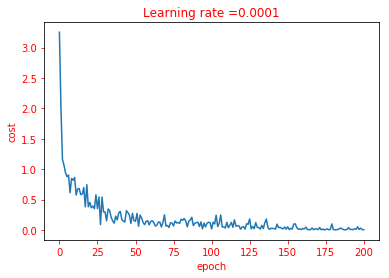

In [21]:
parameters, cost = model(X, Y, layers, alpha, epochs, mini_batch_size, beta1, beta2, epsilon, print_cost=True)

# save parameters
f = open('64_64_64.pkl', 'wb')
pickle.dump(parameters, f)
f.close()

<a id='4.2'></a>
### 4.2 Model performace

* Model performance is measured by *accurancy* metrics on *train set* and *test set*.

In [22]:
# load pre trained parameters
f = open('64_64_64.pkl', 'rb')
parameters = pickle.load(f)
f.close()

pred_train = predict(X, parameters)
pred_test = predict(X_test, parameters)

train_acc = accuracy(pred_train, Y_train)
test_acc = accuracy(pred_test, Y_test)
print("Accuracy on train set: ", train_acc)
print("Accuracy on test set: ", test_acc)

Accuracy on train set:  0.9994
Accuracy on test set:  0.9583


<a id='5'></a>
## 5. Image prediction 

* Parameters acquired during training can be used to recognize real world handwritten digits.
* Function ```image_predict``` does that; it takes as an arguments:
    * image name in string - photo of digit that should be in *example_digits* folder
    * true label of the photo (int)
    * parameters from training
    * *print_softmax* - allows to print whole output of softmax function

In [23]:
def image_predict(image, image_label, parameters, print_softmax=False):
    file_name = 'example_digits/' + image

    image_arr = -imageio.imread(file_name, as_gray=True)
    image_arr = image_arr + 255 # to make background black
    image_arr = image_arr / 255 # normalize values to be betweeen 0 and 1

    image_resized = resize(image_arr, (28, 28), anti_aliasing=False, mode='reflect')
    image_vec = image_resized.reshape((784, 1))

    prediction = predict(image_vec, parameters, print_softmax)

    print('Network prediction: ', np.squeeze(prediction))
    print('True label: ', image_label)

    if (prediction == image_label):
        print('Network recognized digit correctly!')
    else:
        print('Too bad!')

    im = plt.imshow(image_resized, cmap='gray')

<a id='5.1'></a>
### 5.1 Example

* The *example_images* folder contains sample digits written by me.
* As it can be seen network is often wrong, it is probably caused by the noisy background of real world photos.

Network prediction:  2
True label:  4
Too bad!


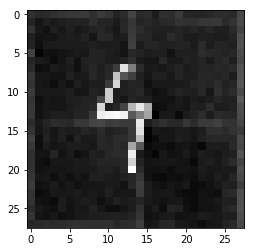

In [24]:
image_predict('four.jpg', 4, parameters)

<br>

* After removing backgruound predictions are better, but not always.

Network prediction:  4
True label:  4
Network recognized digit correctly!


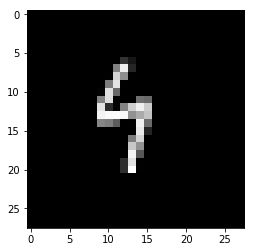

In [25]:
image_predict('four_clean.jpg', 4, parameters)

<a id='6'></a>
## 6. Conclusion

* The model has been successfully implemented and it works.
* Accuracy on the *train set* was $99.94\%$ and on the *test set* $95.83\%$.
* Gap between train set and test set is equal $4.11\%$ and accuracy on train set is almost $100\%$ whitch might indicate that model is overfitting.
* Network does not perform well on real world images.
* Next steps:
    * Adding some form of regularization, eg *Dropout* or *L₂ Regularization*.
    * Using Data Augmentation or training on more realistic data set could make model perform better on real world digits.
<br>
<br>

*This project was inspired by Deep Learning Specialization Courses by Andrew Ng on Coursera.*